### Our Plan

**Introduction** - Our startup team has determined that machine learning will play a role in providing risk evaluation as a service for retail banks. We have access to a dataset from Home Credit Group and are interested in using this data in order to test out various models.

**Business Objective** - Our goal is to provide retail banks with the tools for accurate risk evaluation, utilizing machine learning to predict the probability of a client making a late payment. This approach addresses the need for more effective risk management in lending, aiming to reduce the possible financial losses of bad loans. By deploying this model, banks can improve decision-making in loan approvals, reducing costs associated with defaults, such as legal actions and loss recovery efforts. Ultimately, this leads to a more efficient allocation of resources and a healthier loan portfolio, aligning with our objectives. 

**How Our Model Will Be Used** - Our model is designed to integrate into the retail banks' systems, allowing them to submit client application data and, in return, receive probability scores. These scores represent the likelihood that a client will make a late payment. With these probabilities, banks can create their own tiering systems, allowing flexibility in deciding whether to grant a loan. For example, if the banks are interested in a more strict policy, they could decline any applications that have a 30% probability or above.

**Part 1: Data Understanding & Cleaning** —The first part of our four-step plan involves understanding the dataset we are working with. This involves checking for duplicates and missing values and understanding why they might be missing. We also perform various data cleaning/transformation processes to facilitate a smoother analysis.

**Part 2: Exploratory Data Analysis**—Once we have cleaned and gained an overview of our datasets, the next logical step is to perform some analysis. Since we are dealing with many features, we decided to take an approach that only focuses on features that display relationships with clients having late payments on a loan. This allows us to gain more of an understanding of various components that impact the risk of a loan default. These relationships can help prepare us for our meetings with retail banks by demonstrating previous knowledge of common factors involved in evaluating risk.

**Part 3: Late Payment Probability Prediction** - This part of our strategy is focused on developing a predictive model to estimate the likelihood of a client making a late payment. This predictive model is essential for important our business objective of offering risk evaluation services to retail banks. By automating the assessment of a client's default risk, we can significantly cut costs, reallocate resources more efficiently, and avoid issuing loans with a high likelihood of default. By utilizing the probability values, banks can introduce a risk tiering approach, categorizing applicants into distinct tiers based on their likelihood of default, such as low, medium, and high risk. This method allows for assessing risk on a more granular level, enabling banks to be more selective and offer loans to higher risk individuals within acceptable thresholds. This approach is designed to ensure fairness and accessibility, especially for less privileged individuals.

**Part 4: Model Deployment** - The final part of our plan is to deploy our fully trained model onto google cloud platform in order to demonstrate our product to retail banks and any other businesses that are interested. The code for this part will be located in the `flask_app` folder.

### Data Overview & Cleaning

**Imports**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import shap
from lightgbm import LGBMClassifier
from joblib import dump
import featuretools as ft
from scipy.stats import pointbiserialr
from ydata_profiling import ProfileReport
from xgboost import XGBClassifier
from sklearn.metrics import (auc, confusion_matrix, precision_recall_curve,
                             roc_auc_score, roc_curve, make_scorer,
                             classification_report)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from functions.plot_utils import (annotate_bars, hide_spines,
                                  plot_model_evaluation, plot_learning_curves,
                                  plot_double_conf_matrix)
from tqdm import tqdm
import optuna
from functions.functions import (
    null_summary, reduce_memory_usage, get_columns_starting_with,
    clean_applications_dataset, clean_previous_apps_dataset,
    clean_pos_cash_dataset, get_numerical_categorical_columns,
    compute_correlations_and_pvalues, mutual_information_scores,
    multiple_test_chi2, get_ft_importances, get_objective_xgb,
    get_confusion_matrix_df, compute_ratio_features, create_preprocessor,
    agg_dataframes, bin_ages, get_features_with_importance,
    get_preds_and_probas, calculate_overlap,
    create_preprocessor_with_null_threshold, filter_columns_by_null_threshold,
    mutiple_test_mann_whitney, build_pipeline, convert_days_to_years,
    get_highly_correlated_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
plt.style.use("deeplearning.mplstyle")
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
default_blue = default_colors[0]

In [5]:
applications = reduce_memory_usage(pd.read_csv("data/application_train.csv"))
bureau_balance = reduce_memory_usage(pd.read_csv("data/bureau_balance.csv"))
bureau = reduce_memory_usage(pd.read_csv("data/bureau.csv"))
cc_balance = reduce_memory_usage(pd.read_csv("data/credit_card_balance.csv"))
installments = reduce_memory_usage(
    pd.read_csv("data/installments_payments.csv"))
pos_cash = reduce_memory_usage(pd.read_csv("data/POS_CASH_balance.csv"))
previous_applications = reduce_memory_usage(
    pd.read_csv("data/previous_application.csv"))

**Application Overview & Cleaning**

In [6]:
applications.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
print(f"Application shape: {applications.shape}")
print(f"Application duplicated: {applications.duplicated().sum()}")

Application shape: (307511, 122)
Application duplicated: 0


In [9]:
# Create pandas profiling report for univariate analysis
profile = ProfileReport(applications, title="Application Report", minimal=True)
profile.to_file(output_file="app_report.html")

In [7]:
applications = clean_applications_dataset(applications)

In [9]:
null_summary_applications = null_summary(applications)
null_summary_applications.head(10)

,feature,null_values_count,null_values_pct
47,COMMONAREA_AVG,214865,69.872297
55,NONLIVINGAPARTMENTS_AVG,213514,69.432963
53,LIVINGAPARTMENTS_AVG,210199,68.354953
51,FLOORSMIN_AVG,208642,67.848630
46,YEARS_BUILD_AVG,204488,66.497784
20,OWN_CAR_AGE,202929,65.990810
52,LANDAREA_AVG,182590,59.376738
44,BASEMENTAREA_AVG,179943,58.515956
40,EXT_SOURCE_1,173378,56.381073
56,NONLIVINGAREA_AVG,169682,55.179164


In [10]:
large_null_cols = null_summary_applications[
    null_summary_applications['null_values_pct'] > 35]['feature'].values

In [11]:
default_rate_with_nulls = applications[
    applications[large_null_cols].isnull().any(axis=1)]['TARGET'].mean()

default_rate_without_nulls = applications[
    applications[large_null_cols].notnull().all(axis=1)]['TARGET'].mean()

print(
    f"Late payment rate with nulls in high-null columns: {default_rate_with_nulls}"
)
print(
    f"Late payment rate without nulls in high-null columns: {default_rate_without_nulls}"
)

Late payment rate with nulls in high-null columns: 0.08166235886273976
Late payment rate without nulls in high-null columns: 0.060351866973498626


- Our application train dataset consists of 122 columns and approximately 307k rows. After generating our Pandas profiling report, we performed a univariate analysis of the features to identify possible outliers and errors in the data. We identified unknown categories such as (XNA Unknown) in gender, organization, and family status, which we replaced with null. We identified some errors in the day's columns that contained positive values, which did not make sense, so we replaced them with nan. We investigated the distributions of features with high null values like COMMONAREA_MODE, COMMONAREA_AVG, etc., displaying that they are almost identical (AVG, MEDI, MODE). So, moving forward, we will keep the AVG features and drop the MEDI and MODE. This allows us to reduce complexity while still retaining all the same information.


- Our null values summary displays columns containing normalized information about the building where the client lives and ext source 1 (external info about credit score), with large amounts of missing values. When we took a closer look at the house/building features, we observed that they all are when one of the values is null. What does that mean? It could indicate the borrower didn't fill that section in, or it could mean it does not apply to them; it's hard to pinpoint it exactly. We also computed the default/late payment rate for groups where many of the columns were missing vs those that were not. Interestingly, the late payment rate was slightly higher for those with large amounts of nulls.

**Bureau/Bureau Balance Overview & Cleaning**

In [16]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [18]:
print(f"Bureau shape:{bureau.shape}")
print(f"Bureau balance shape:{bureau_balance.shape}")
print(f"Bureau duplicates:{bureau.duplicated().sum()}")
print(f"Bureau balance duplicates:{bureau_balance.duplicated().sum()}")

Bureau shape:(1716428, 17)
Bureau balance shape:(27299925, 3)
Bureau duplicates:0
Bureau balance duplicates:0


In [2]:
profile = ProfileReport(bureau, title="Bureau Report", minimal=True)
profile.to_file(output_file="bureau_report.html")

In [19]:
null_summary_bureau = null_summary(bureau)
null_summary_bureau.head()

,feature,null_values_count,null_values_pct
16,AMT_ANNUITY,1226791,71.473490
8,AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
7,DAYS_ENDDATE_FACT,633653,36.916958
12,AMT_CREDIT_SUM_LIMIT,591780,34.477415
11,AMT_CREDIT_SUM_DEBT,257669,15.011932


In [17]:
null_summary_bureau_balance = null_summary(bureau_balance)
null_summary_bureau_balance.head()

,feature,null_values_count,null_values_pct
0,SK_ID_BUREAU,0,0.0
1,MONTHS_BALANCE,0,0.0
2,STATUS,0,0.0


- Our bureau's datasets contain information about the client's previous credit history. We observe that columns related to annuity of the credit bureau and the maximum amount overdue display a large amount of null values. As we stated before, we will not be removing these just yet as they could contain valuable information

**Previous Applications Overview & Cleaning**

In [19]:
previous_applications.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
print(f"Previous applications shape: {previous_applications.shape}")
print(
    f"Previous applications duplicated: {previous_applications.duplicated().sum()}"
)

Previous applications shape: (1670214, 37)
Previous applications duplicated: 0


In [3]:
profile = ProfileReport(previous_applications,
                        title="Previous Applications Report",
                        minimal=True)
profile.to_file(output_file="previous_apps_report.html")

In [9]:
previous_applications = clean_previous_apps_dataset(previous_applications)

In [19]:
null_summary_previous_applications = null_summary(previous_applications)
null_summary_previous_applications.head(10)

,feature,null_values_count,null_values_pct
13,RATE_INTEREST_PRIMARY,1664263,99.643698
14,RATE_INTEREST_PRIVILEGED,1664263,99.643698
31,DAYS_FIRST_DRAWING,1607509,96.245691
15,NAME_CASH_LOAN_PURPOSE,1600579,95.830774
19,CODE_REJECT_REASON,1358337,81.327123
24,NAME_PRODUCT_TYPE,1063666,63.684414
22,NAME_GOODS_CATEGORY,950809,56.927376
35,DAYS_TERMINATION,898978,53.824121
6,AMT_DOWN_PAYMENT,895844,53.636480
12,RATE_DOWN_PAYMENT,895844,53.636480


In [10]:
previous_applications = previous_applications.drop(columns=[
    'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING',
    'NAME_CASH_LOAN_PURPOSE'
])

- Our previous applications dataset contains data about the clients previous loan applications. We observe columns such as interest rate privileged,primary, days first drawing, and name cash loan purpose contain almost all null values (99%). Further investigating, interest rate primary and privileged only are applicable for consumer loans (hence the large amount of null values), while days first drawing was only applicable to revolving loans. We also observed the name cash loan purpose had values of XNA (assuming not applicable), this makes sense as those loans were not of cash purpose. So we will leave these values as null, because imputing might not make sense here.

**Pos_Cash Overview & Cleaning**

In [23]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [24]:
print(f"Pos Cash shape: {pos_cash.shape}")
print(f"Pos Cash duplicated: {pos_cash.duplicated().sum()}")

Pos Cash shape: (10001358, 8)
Pos Cash duplicated: 0


In [12]:
pos_cash = clean_pos_cash_dataset(pos_cash)

In [22]:
null_summary_pos_cash = null_summary(pos_cash)
null_summary_pos_cash

,feature,null_values_count,null_values_pct
4,CNT_INSTALMENT_FUTURE,26087,0.260835
3,CNT_INSTALMENT,26071,0.260675
5,NAME_CONTRACT_STATUS,2,0.000020
0,SK_ID_PREV,0,0.000000
1,SK_ID_CURR,0,0.000000
2,MONTHS_BALANCE,0,0.000000
6,SK_DPD,0,0.000000
7,SK_DPD_DEF,0,0.000000


- The pos_cash dataframe contains information about the monthly balance of client's previous loans. We see that there is very few missing values (0.2%) for the installment columns.

**Installments Payments Overview & Missing Values**

In [27]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.0,25425.0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [28]:
print(f"Installments Cash shape: {installments.shape}")
print(f"Installments Cash duplicated: {installments.duplicated().sum()}")

Installments Cash shape: (13605401, 8)
Installments Cash duplicated: 0


In [29]:
null_summary_installments_payments = null_summary(installments)
null_summary_installments_payments.head()

,feature,null_values_count,null_values_pct
5,DAYS_ENTRY_PAYMENT,2905,0.021352
7,AMT_PAYMENT,2905,0.021352
0,SK_ID_PREV,0,0.000000
1,SK_ID_CURR,0,0.000000
2,NUM_INSTALMENT_VERSION,0,0.000000


- The installment payments dataset contains information about past payment dates for each installment of previous credits. We observe very few null values (0.2%).

**Credit Card Balance Overview & Cleaning**

In [128]:
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [30]:
print(f"Credit Card Balance shape: {pos_cash_balance.shape}")
print(f"Credit Card Balance duplicated: {pos_cash_balance.duplicated().sum()}")

Credit Card Balance shape: (10001358, 8)
Credit Card Balance duplicated: 0


In [129]:
cc_balance.shape

(3840312, 23)

In [48]:
null_summary_cc_balance = null_summary(cc_balance)
null_summary_cc_balance.head()

,feature,null_values_count,null_values_pct
10,AMT_PAYMENT_CURRENT,767988,19.998063
5,AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
18,CNT_DRAWINGS_POS_CURRENT,749816,19.524872
7,AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
8,AMT_DRAWINGS_POS_CURRENT,749816,19.524872


- Our credit card balance dataset contains information about the monthly balance of clients previous credit card loans. Features related to amount/number drawn at ATMs and buying goods during the previous month display a moderate amount of null values (20%).

###  Analysis of Features & Target

**Target Variable Distribution**

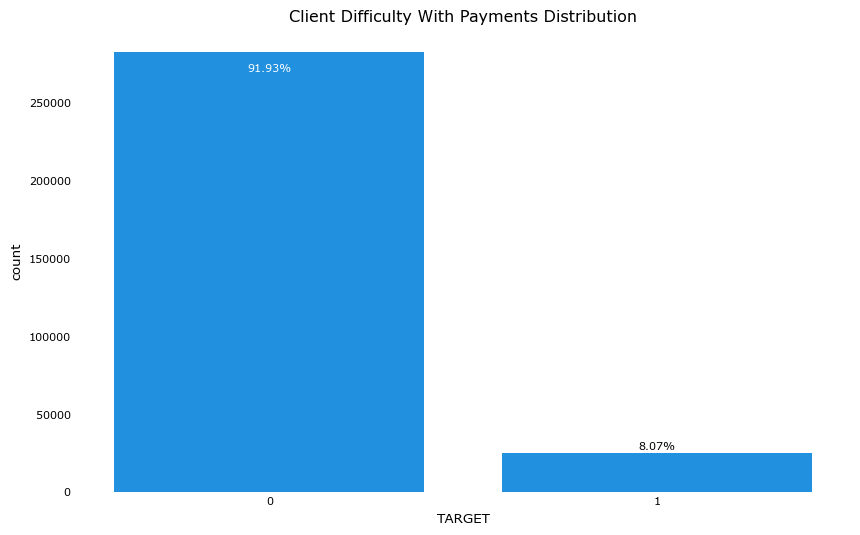

In [12]:
plt.figure(figsize=(10, 6))
plt.title('Client Difficulty With Payments Distribution')
ax = sns.countplot(applications, x='TARGET', color=default_blue)
annotate_bars(ax, percentage=True)
hide_spines(ax)
plt.show()

- The first step in our analysis is to gain an undertanding of the distribution of our target variable. As per the description the target variable is defined : 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases. We are working with a highly imbalanced dataset, where approximately 92% of the clients did not have any late payement troubles and 8% did. This is something we will be keeping in mind during our modeling phase.

**Pointbiserial Correlation**

In [13]:
num_cols, cat_cols = get_numerical_categorical_columns(
    applications, binary_as_categorical=True)
cat_cols = cat_cols + [col for col in num_cols if 'RATING' in col]
num_cols = [col for col in num_cols if 'RATING' not in col]

In [14]:
num_cols = num_cols + ['TARGET']
corr_matrix = compute_correlations_and_pvalues(applications[num_cols],
                                               'TARGET',
                                               'pointbiserial').iloc[1:, :]

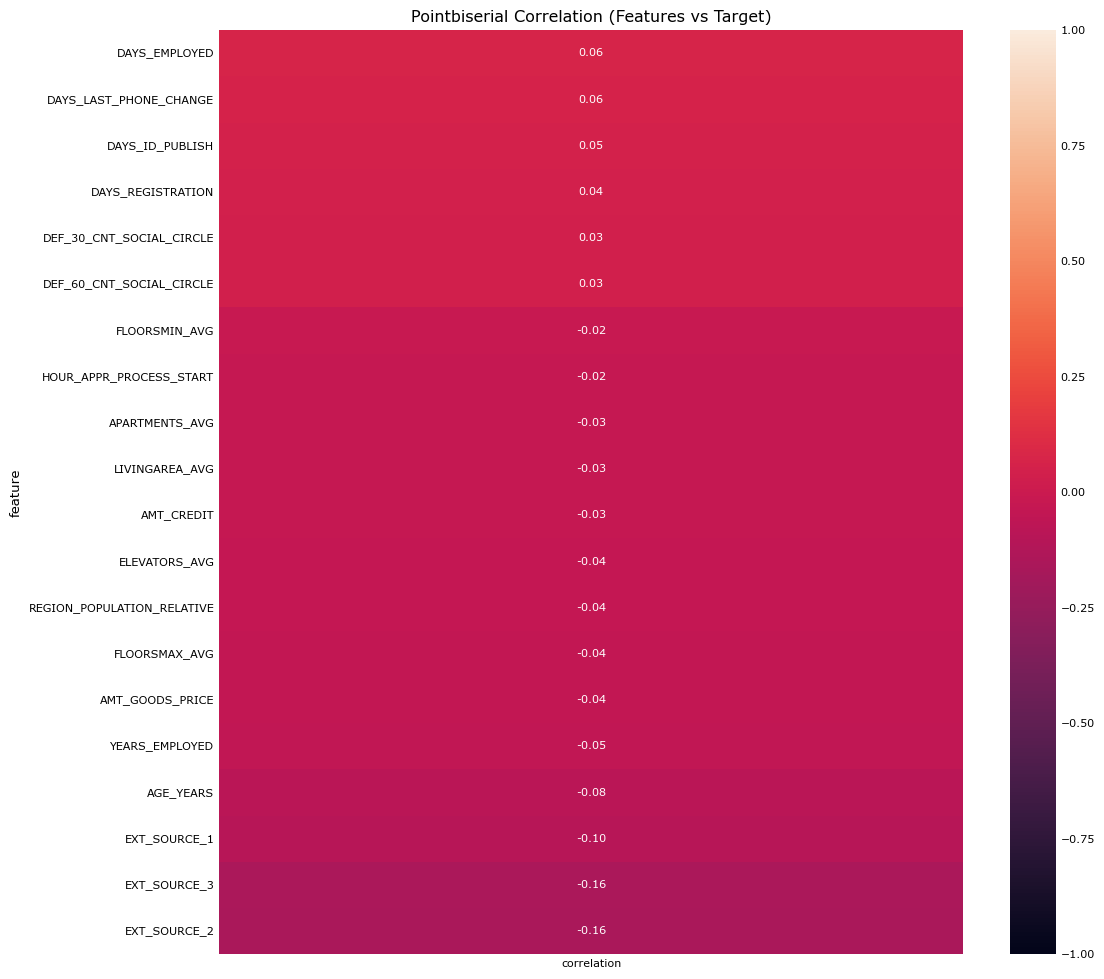

In [15]:
plt.figure(figsize=(12, 12))
plt.title('Pointbiserial Correlation (Features vs Target)')
sns.heatmap(
    corr_matrix[abs(corr_matrix['correlation']) >= 0.02].set_index('feature')[[
        'correlation'
    ]],
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1)
plt.show()

- Our chart above displays a heatmap with the point biserial correlation values in relation to our binary target. Point-biserial correlation is used for continuous variables vs binary, which is our case. The EXT_SOURCE variables have the largest correlation (-0.10,-0.16) with our target. As per the documentation, they represent a normalized score from external data sources. It is not one hundred percent clear precisely what the score is; we are assuming that it's some credit score from another institution. Following, we see that age and days employed  both display a low-mild amount of correlation (-0.08 and 0.06).

**Hypothesis Testing**

**Is there a significant association between our categorical features and the acceptance/rejection of a loan?**

**Null Hypothesis**: There is no association between a specific categorical feature (e.g.,Gender,etc. ) and late payment.  
**Alternative Hypothesis**: There is an association between a specific categorical feature and late payment

In [16]:
alpha = round(0.05 / len(cat_cols), 3)
alpha

0.001

In [17]:
chi2_dict = multiple_test_chi2(applications[cat_cols].drop('TARGET', axis=1),
                               applications['TARGET'])

In [18]:
{k: v for k, v in chi2_dict.items() if v[1] > 500}

{'CODE_GENDER': [4.394091339983112e-202, 920.0057254249849],
 'NAME_INCOME_TYPE': [1.9281456056861122e-266, 1253.4708080924986],
 'NAME_EDUCATION_TYPE': [2.4476812052198174e-219, 1019.2131873088356],
 'NAME_FAMILY_STATUS': [7.07008034624966e-108, 504.5154516971813],
 'OCCUPATION_TYPE': [3.7844998567642684e-288, 1402.8467961927515],
 'ORGANIZATION_TYPE': [1.8427554957590874e-152, 899.6501407824151],
 'FLAG_EMP_PHONE': [2.5306059279614537e-143, 649.75118051112],
 'REG_CITY_NOT_LIVE_CITY': [1.0752352295806783e-133, 605.4816592205171],
 'REG_CITY_NOT_WORK_CITY': [7.98127695863221e-176, 799.2180447198825],
 'FLAG_DOCUMENT_3': [1.8557477135709125e-133, 604.3919581828716],
 'REGION_RATING_CLIENT': [1.8283164955910817e-232, 1067.1926919578827],
 'REGION_RATING_CLIENT_W_CITY': [5.05571529094165e-249, 1143.446337622771]}

**Is there a significant difference in the distribution of our numerical features and late payment of a client?**

**Null Hypothesis**:There is no difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had late payment and those who have not.

**Alternative Hypothesis**: There is a difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had late payments those who have not.

In [19]:
features_for_hyp_testing = corr_matrix[abs(corr_matrix['correlation']) >=
                                       0.05]['feature'].values
mutiple_test_mann_whitney(applications[features_for_hyp_testing],
                          applications['TARGET'])

{'DAYS_EMPLOYED': [0.0, 2100007077.5],
 'DAYS_LAST_PHONE_CHANGE': [6.1941416200791875e-195, 3109778089.5],
 'DAYS_ID_PUBLISH': [1.3917745563748238e-186, 3118165526.0],
 'AGE_YEARS': [0.0, 4091325258.5],
 'EXT_SOURCE_1': [0.0, 830430510.0],
 'EXT_SOURCE_3': [0.0, 2958253947.5],
 'EXT_SOURCE_2': [0.0, 4584913929.5]}

- We performed multiple Chi-Square tests to see if there is an association between our categorical features and late payments. The resulting dictionary displays the corresponding p-values and chi2 values for each feature. Due to the size of our dataset, many of our features are deemed significant. That said, we filtered out some features with the most significant chi2 values to take a closer look. We can see that gender, income type,education and various other categortical features were all deemed significant.


- We followed a similar approach for our numerical variables, only choosing the more correlated variables and using a Mann–Whitney U test. We utilized a nonparametric test because our data did not follow a normal distribution, which is an assumption when using a test like a t-test. Features such as ext sources, age, days employed, and region rating were all deemed significant, with p-values approaching 0. Moving forward, we will be using the information gained from these important features and trying to visualize these relationships to gain a better understanding.

**Important Features Visualizations**

In [13]:
applications['YEARS_EMPLOYED'] = convert_days_to_years(
    applications['DAYS_EMPLOYED'])

In [21]:
cols_to_plot = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE_YEARS',
    'YEARS_EMPLOYED', 'AMT_CREDIT'
]

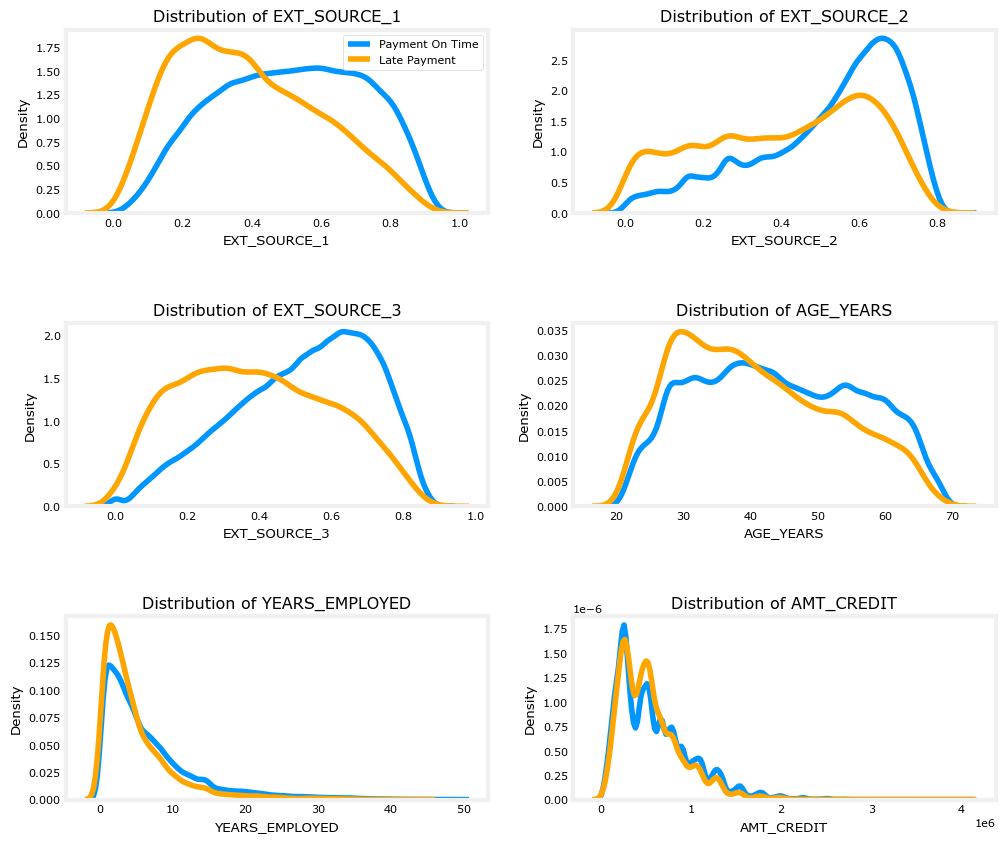

In [38]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(3, 2, i)

    sns.kdeplot(data=applications[applications['TARGET'] == 0],
                x=col,
                label='Payment On Time')
    sns.kdeplot(data=applications[applications['TARGET'] == 1],
                x=col,
                label='Late Payment',
                color='orange')
    plt.title(f'Distribution of {col}')
    if i == 1:
        plt.legend()
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

In [42]:
applications['AGE_BINNED'] = bin_ages(applications['AGE_YEARS'])
cat_cols_plot = [
    'CODE_GENDER', 'AGE_BINNED', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
    'NAME_CONTRACT_TYPE', 'REGION_RATING_CLIENT_W_CITY'
]

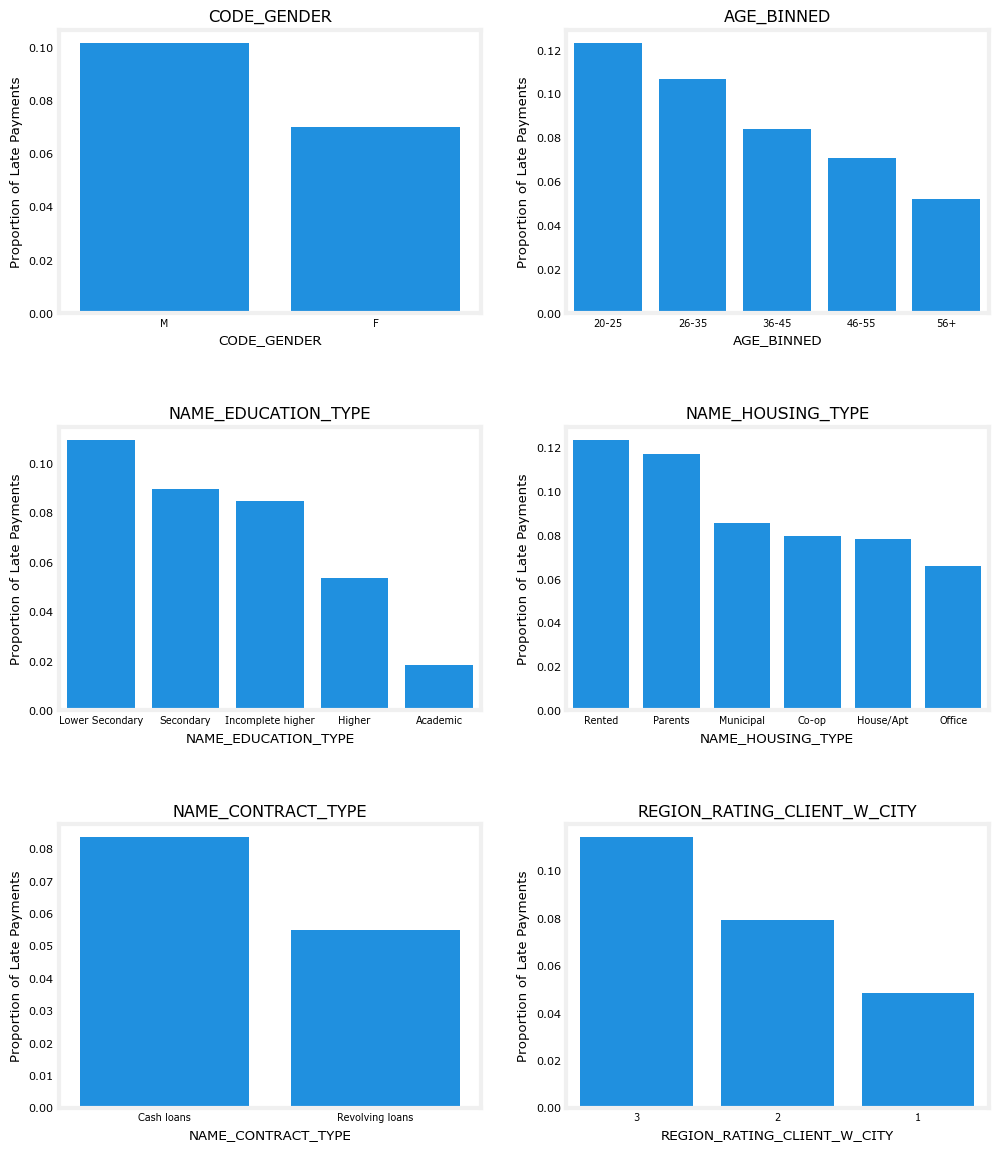

In [43]:
plt.figure(figsize=(12, 14))
for i, col in enumerate(cat_cols_plot, 1):
    plt.subplot(3, 2, i)
    plt.title(col)
    proportion_late = applications.groupby(
        col, observed=True)['TARGET'].mean().reset_index().sort_values(
            by='TARGET', ascending=False)
    fig = sns.barplot(proportion_late,
                      x=col,
                      y='TARGET',
                      order=proportion_late[col])
    plt.ylabel('Proportion of Late Payments')
    plt.xticks(fontsize=7)
plt.subplots_adjust(hspace=0.4, wspace=0.2)

**Summary of Important Features**


**EXT_SOURCES**—Our kde-plots of the EXT_SOURCE features and age display a clear trend: clients who made late payments tended to have lower normalized scores, particularly more density around the 0.2-0.3 area, whereas clients who did not make late payments had higher scores.

**Age & Age Binned**—We binned the clients' ages and computed the proportion of late payments in each age group. Here, we can see a clear trend: younger age groups tended to have a higher late payment rate, with the 20-25 age group displaying the largest (12%), followed by 26-35 (11%).

**Gender**—We see that the proportion of men who defaulted was around 10% compared to females, who only displayed a 7% default rate. This could indicate that our dataset is biased towards males making late payments.

**Education Type**—The education type also displayed an interesting pattern. People who only finished lower secondary school had the highest late payment rate (11%), followed by secondary (9%). There is a clear pattern where people who have completed higher education display a lower proportion of loan default. 

**Housing Type**—Housing type also shows a pattern where people who live in rented apartments and with their parents have a higher late payment rate (12% and 11%).

**Contract Type**—Cash loans have a higher default rate than revolving loans. Cash loans display a default rate of 8% compared to revolving loans, which are only around 5%.

**Years Employed**—We converted days employed into years as it is easier to understand. Comparing the distributions of clients with and without late payments, we see there is a slightly higher density closer to the zero area of years employed for late-paying clients.

**Region Rating** - The region rating column is a rating of the region where the client lives, taking the city into account (1,2,3). We observe that the late payment rate decreases as the rating goes down. Indicating that clients who live in the higher-ranked ratings tend to have a higher late payment rate

### Modeling

**Data Splitting & Dummy Model**

In [15]:
X = applications.drop(columns=['TARGET', 'AGE_BINNED', 'YEARS_EMPLOYED'])
y = applications['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.15,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15 / (1 - 0.15),
                                                  stratify=y_train,
                                                  random_state=42)

In [16]:
print(f"Training shape {X_train.shape}")
print(f"Validation/Testing shape {X_val.shape}")

Training shape (215257, 88)
Validation/Testing shape (46127, 88)


In [17]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_preds, y_probas = get_preds_and_probas(dummy_clf, X_val)
print(f"ROC_AUC: {roc_auc_score(y_val,y_probas)}")

ROC_AUC: 0.49955101924293355


- The first step before developing any models is to split our data. Since we have sufficient data, we have split it into three parts: training, validation, and testing. The validation set will be used for hyperparameter tuning, feature engineering, etc., while the test set is the hold-out set we won't touch until the end to test our model on unseen data. After some experimentation, we decided to split the data into 70/15/15. This split allows for sufficient training data and enough validation and testing for confidence in our model evaluations. Our primary metric will be focused on ROC AUC as it measures the model's ability to distinguish between clients who will default and those who won't. From the point of view of retail banks, a model's ability to differentiate between the two classes allows for a good balance of performance in being able to identify risky and nonrisky loans.

**Baseline Model With Standard Features**

In [18]:
X_train_temp = X_train.drop('SK_ID_CURR', axis=1)
X_val_temp = X_val.drop('SK_ID_CURR', axis=1)

In [19]:
xgb_model = XGBClassifier(random_state=42,
                          max_depth=2,
                          n_estimators=1000,
                          enable_categorical=True,
                          early_stopping_rounds=30,
                          eval_metric='auc',
                          verbosity=2)

In [22]:
xgb_model.fit(X_train_temp,
              y_train,
              eval_set=[(X_train_temp, y_train), (X_val_temp, y_val)],
              verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [23]:
_, y_probas = get_preds_and_probas(xgb_model, X_val_temp)
print(f'ROC AUC {roc_auc_score(y_val,y_probas)}')

ROC AUC 0.7607139456445142


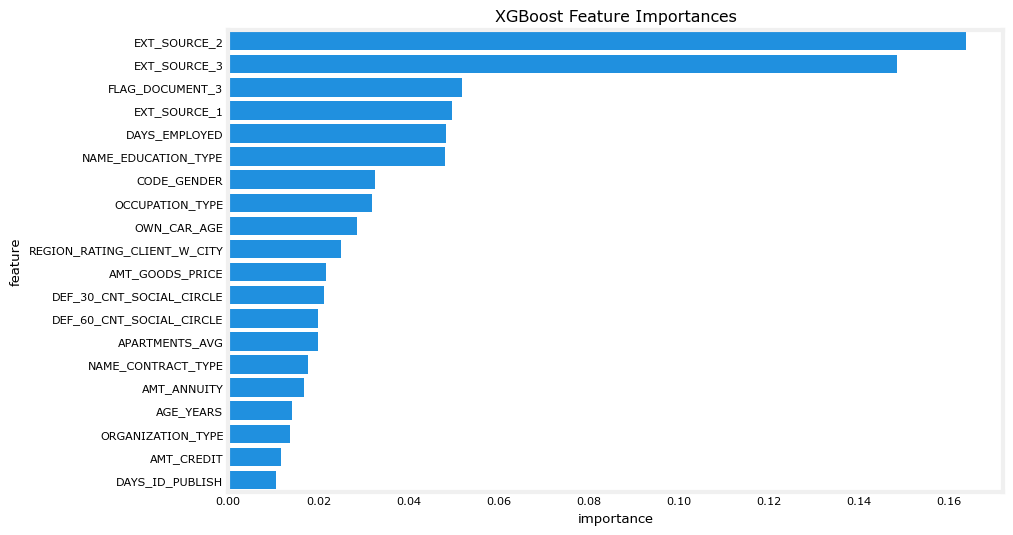

In [25]:
xgb_ft_importance = get_ft_importances(X_train_temp, xgb_model)
plt.figure(figsize=(10, 6))
plt.title('XGBoost Feature Importances')
sns.barplot(xgb_ft_importance.head(20), x='importance', y='feature')
plt.show()

- We started with an XGBoost model; we utilized the internal categorical and null handling, allowing us to evaluate performance and feature importance without complex preprocessing. Without any tuning, the resulting roc auc was approximately 0.76. Our feature importance plot shows that external source features contribute most to the model's predictions. This model only utilizes current data from the client's applications. Building simpler models with fewer features is helpful because it gives us a baseline against which to work against.

**Initial Hyperparameter Tuning**

In [26]:
objective_v1 = get_objective_xgb(X_train_temp, X_val_temp, y_train, y_val)

In [53]:
study_v1 = optuna.create_study(direction='maximize')
study_v1.optimize(objective_v1, n_trials=75)

In [28]:
study_v1.best_value

0.7621326920330935

In [29]:
study_v1.best_params

{'learning_rate': 0.11440798039238656,
 'xgb_max_depth': 4,
 'xgb_scale_pos_weight': 2.894303855782104,
 'xgb_min_child_weight': 1,
 'xgb_subsample': 0.8154199301685177,
 'xgb_colsample_bytree': 0.5194615934531539,
 'lambda': 1.8626625969836414,
 'alpha': 1.0498825228697661,
 'gamma': 1.9463670817523517}

- After our first round of hyperparameter tuning only with the features in the applications dataset, we can see that our roc auc slightly increased to around  0.762. Our next steps will involve utilizing the client's previous data to create new features and reevaluate our model.

**Feature Engineering/Aggregation**

In [36]:
dfs_to_agg = [(bureau, 'BUREAU'), (previous_applications, 'PREV_APP'),
              (pos_cash, 'POS_CASH'), (installments, 'INSTALLMENT'),
              (cc_balance, 'CREDIT_CARD')]

In [37]:
X_train_agg = X_train.copy()
X_val_agg = X_val.copy()
X_test_agg = X_test.copy()

for df_to_agg, name in dfs_to_agg:
    X_train_agg = agg_dataframes(X_train_agg, df_to_agg, 'SK_ID_CURR', name)
    X_val_agg = agg_dataframes(X_val_agg, df_to_agg, 'SK_ID_CURR', name)
    X_test_agg = agg_dataframes(X_test_agg, df_to_agg, 'SK_ID_CURR', name)

In [38]:
train_val_overlap = calculate_overlap(X_train_agg, X_val_agg)
train_test_overlap = calculate_overlap(X_train_agg, X_test_agg)
val_test_overlap = calculate_overlap(X_val_agg, X_test_agg)
print(f"Overlap Train-Val: {train_val_overlap}")
print(f"Overlap Train-Test: {train_test_overlap}")
print(f"Overlap Val-Test: {val_test_overlap}")

Overlap Train-Val: 0
Overlap Train-Test: 0
Overlap Val-Test: 0


In [392]:
print(f"Duplicates Train: {X_train_agg.duplicated().sum()}")
print(f"Duplicates Test: {X_test_agg.duplicated().sum()}")
print(f"Duplicates Val: {X_val_agg.duplicated().sum()}")

Duplicates Train: 0
Duplicates Test: 0
Duplicates Val: 0


In [43]:
del bureau
del previous_applications
del pos_cash
del installments
del cc_balance

In [44]:
X_train_agg = X_train_agg.drop('SK_ID_CURR', axis=1)
X_val_agg = X_val_agg.drop('SK_ID_CURR', axis=1)
X_test_agg = X_test_agg.drop('SK_ID_CURR', axis=1)

In [45]:
X_train_agg.shape

(215257, 520)

- In our code above, we created new aggregated datasets to enrich our features. We used our agg_dataframes function to create statistical summaries of clients' previous credit/loan history. We also checked for any overlap and duplicates, as sometimes, when performing multiple aggregations, there can be errors and possible data leakage.

**Removing Highly Correlated Features**

In [46]:
corr_pairs = get_highly_correlated_features(X_train_agg, 0.8)

In [47]:
corr_pairs.head()

,Feature_1,Feature_2,Correlation
0,CNT_CHILDREN,CNT_FAM_MEMBERS,0.878563
1,AMT_CREDIT,AMT_GOODS_PRICE,0.987005
2,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.951846
3,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,0.864238
4,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.825880


In [48]:
cols_to_drop = corr_pairs['Feature_2'].unique()

In [49]:
X_train_agg_filtered = X_train_agg.drop(columns=cols_to_drop)
X_val_agg_filtered = X_val_agg.drop(columns=cols_to_drop)

- In our code above, we utilized a simple approach and removed features that were highly correlated with each other. Even though tree-based models are not sensitive to multicollinearity, having a lot of correlated features can make interpretability less reliable and make the model more prone to overfitting. This also allows us to reduce the dimensionality of our dataset, making it easier to work with.

**Model With Newly Engineered Features**

In [308]:
xgb_model.fit(X_train_agg_filtered,
              y_train,
              eval_set=[(X_train_agg_filtered, y_train),
                        (X_val_agg_filtered, y_val)])

In [61]:
train_val_results = xgb_model.evals_result()
print(f"Training AUC {max(train_val_results['validation_0']['auc'])}")
print(f"Eval AUC {max(train_val_results['validation_1']['auc'])}")

Training AUC 0.8033150948305476
Eval AUC 0.7793262017134804


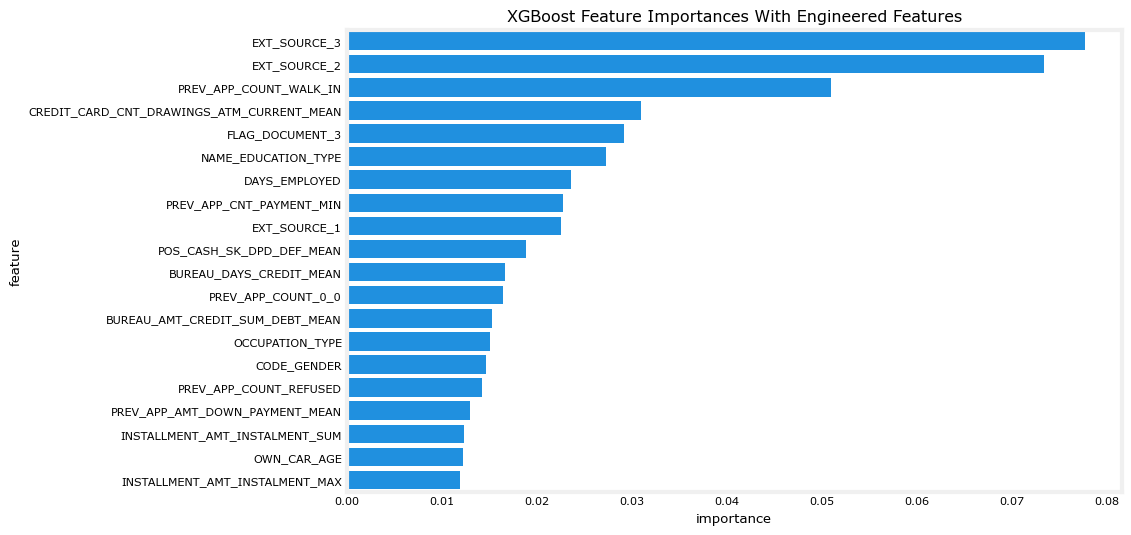

In [63]:
ft_importances_agged = get_ft_importances(X_train_agg_filtered, xgb_model)
fts_with_importance = get_features_with_importance(ft_importances_agged)
plt.figure(figsize=(10, 6))
plt.title('XGBoost Feature Importances With Engineered Features')
sns.barplot(ft_importances_agged.head(20), x='importance', y='feature')
plt.show()

- After establishing some baseline models with our original feature set from the application dataset, the next step was to enrich this dataset by utilizing all of the previous data we had from our clients. We re-ran the model using the new features, which increased our roc auc to approximately 78%. We are slightly overfitting (training vs. eval metric) with the latest features, but not extensively. Our new feature importance splot displays similar results where the ext source features are most important, followed by some of our new integrated features. We will use permutation importance in our next step for further feature selection.

**Permuation Importance**

In [65]:
perm_importance_results = permutation_importance(xgb_model,
                                                 X_val_agg_filtered,
                                                 y_val,
                                                 n_repeats=10,
                                                 scoring='roc_auc',
                                                 random_state=42)

In [66]:
perm_importances = pd.DataFrame({
    'feature':
    X_val_agg_filtered.columns,
    'perm_importance':
    perm_importance_results.importances_mean
}).sort_values(by='perm_importance', ascending=False)

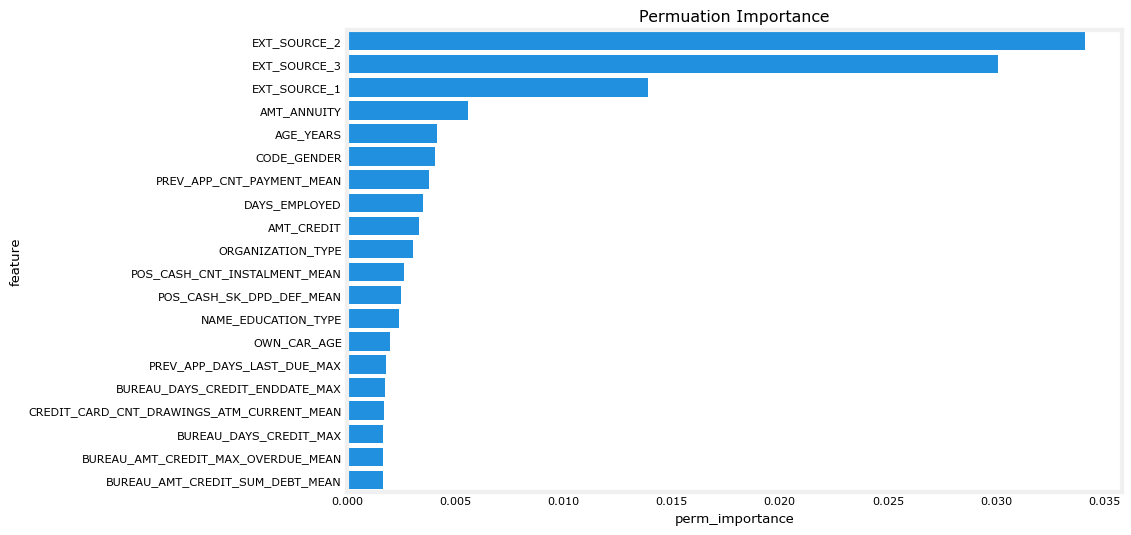

In [67]:
plt.figure(figsize=(10, 6))
plt.title('Permuation Importance')
sns.barplot(perm_importances.head(20), x='perm_importance', y='feature')
plt.show()

In [68]:
important_features_perm = perm_importances[perm_importances['perm_importance']
                                           > 0]['feature'].values

In [69]:
print(
    f"Number Of Features Before Permutation: {X_train_agg_filtered.shape[1]}")
print(f"Reduced Number Of Features By Permutation Importance:\
 {X_train_agg_filtered[important_features_perm].shape[1]}")

Number Of Features Before Permutation: 258
Reduced Number Of Features By Permutation Importance: 130


In [70]:
X_train_perm = X_train_agg_filtered[important_features_perm]
X_val_perm = X_val_agg_filtered[important_features_perm]

- We performed permuation importance on our newly reduced feature set. What permutation importance does is it shuffles each feature and records the effect it has on our roc auc. If we shuffle a feature and our metric decreases this indicates that the feature was contributing to the models output. On the contrary we had some negative permuation importance values, which  indicates that when we shuffle these features are metric actually increased, which means that these features might have been just introducing noise and not benifiting our model.

**Hyperparameter Tuning With Engineered Features**

In [102]:
objective_v2 = get_objective_xgb(X_train_perm, X_val_perm, y_train, y_val)

In [109]:
study_v2 = optuna.create_study(direction='maximize')
study_v2.optimize(objective_v2, n_trials=75)

In [104]:
study_v2.best_value

0.7817757173110054

In [261]:
best_params_v2 = {
    param_name.replace('xgb_', ''): value
    for param_name, value in study_v2.best_params.items()
}

In [251]:
best_params_v2 = {
    'learning_rate': 0.132632842111245,
    'max_depth': 3,
    'scale_pos_weight': 1.8351210188548865,
    'min_child_weight': 3,
    'subsample': 0.9108409176869043,
    'colsample_bytree': 0.8224093804785,
    'lambda': 1.074848177981751,
    'alpha': 0.19744634519170434,
    'gamma': 0.11736488032866554
}

- We performed another round of hyperparameter tuning with the newly engineered features included. Our default parameters show a slight increase from 0.77 to 0.78. It is clear that hyperparameter tuning can help slightly, but creating and engineering features is more important. In the next section, we will evaluate this newly tuned model further.

**Evaluating Tuned Model**

In [256]:
xgb_tuned_v2 = XGBClassifier(**best_params_v2,
                             random_state=42,
                             enable_categorical=True,
                             n_estimators=750,
                             eval_metric='auc',
                             early_stopping_rounds=20)
xgb_tuned_v2.fit(X_train_perm,
                 y_train,
                 eval_set=[(X_train_perm, y_train), (X_val_perm, y_val)],
                 verbose=False)

XGBClassifier(alpha=0.19744634519170434, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8224093804785, device=None,
              early_stopping_rounds=20, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=0.11736488032866554,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.074848177981751,
              learning_rate=0.132632842111245, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None, ...)

In [257]:
train_val_results = xgb_tuned_v2.evals_result()
print(f"Train AUC {max(train_val_results['validation_0']['auc'])}")
print(f"Validation AUC {max(train_val_results['validation_1']['auc'])}")

Train AUC 0.8245055957655958
Validation AUC 0.7818225196507765


In [258]:
y_preds, y_probas = get_preds_and_probas(xgb_tuned_v2, X_val_perm)

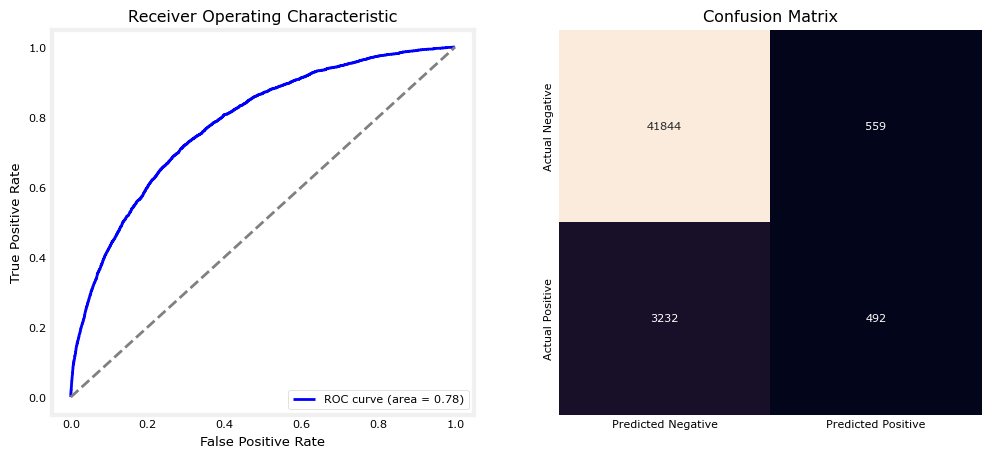

In [259]:
roc_auc = roc_auc_score(y_val, y_probas)
conf_matrix_xgb_tuned_v1 = get_confusion_matrix_df(y_val, y_preds)
fpr, tpr, thresholds = roc_curve(y_val, y_probas)
plot_model_evaluation(fpr, tpr, roc_auc, conf_matrix_xgb_tuned_v1)

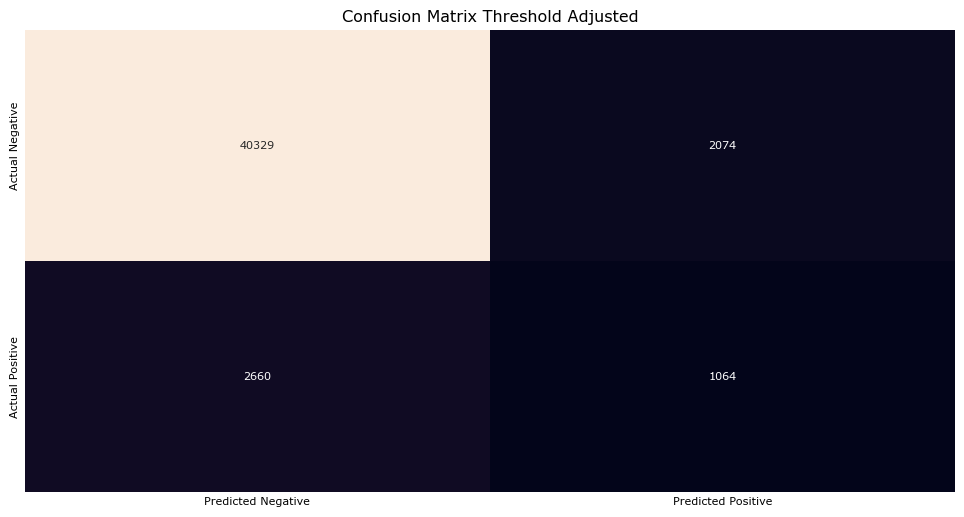

In [260]:
y_preds_adjusted = (y_probas >= 0.35).astype(int)
conf_matrix_adjusted = get_confusion_matrix_df(y_val, y_preds_adjusted)
plt.figure(figsize=(12, 6))
plt.title('Confusion Matrix Threshold Adjusted')
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='g', cbar=False)
plt.show()

In [132]:
explainer = shap.TreeExplainer(xgb_tuned_v2,
                               feature_names=X_train_perm.columns)
shap_values = explainer(X_val_perm)

In [160]:
misclassified_index_fn = np.where((y_val == 1) & (y_probas < 0.05))[0][5]
misclassified_index_fp = np.where((y_val == 0) & (y_probas > 0.5))[0][0]

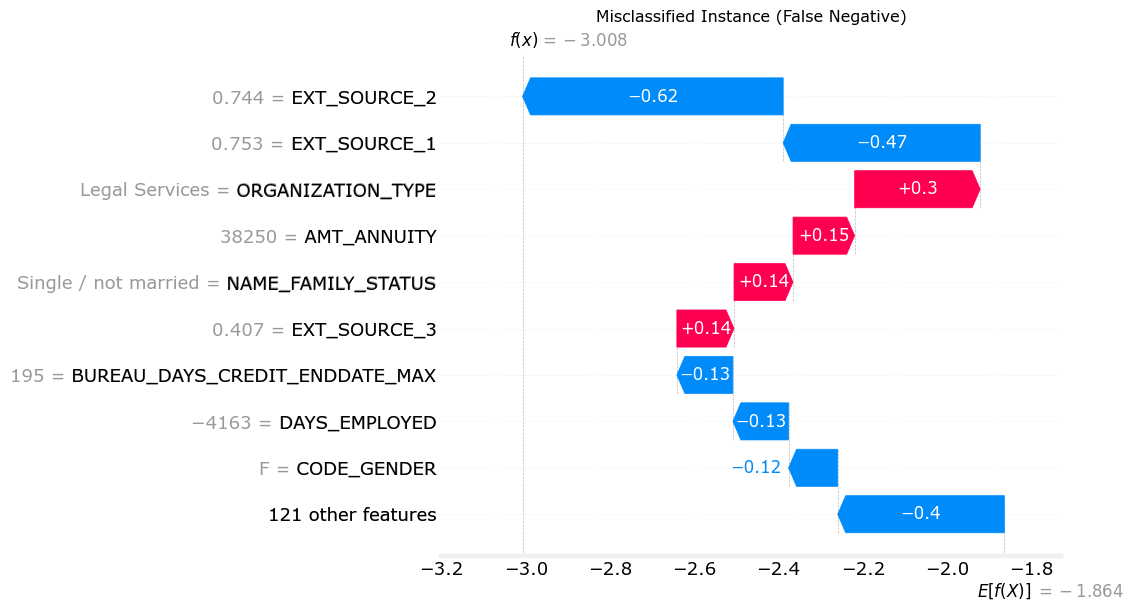

In [161]:
plt.title('Misclassified Instance (False Negative)')
shap.plots.waterfall(shap_values[misclassified_index_fn])

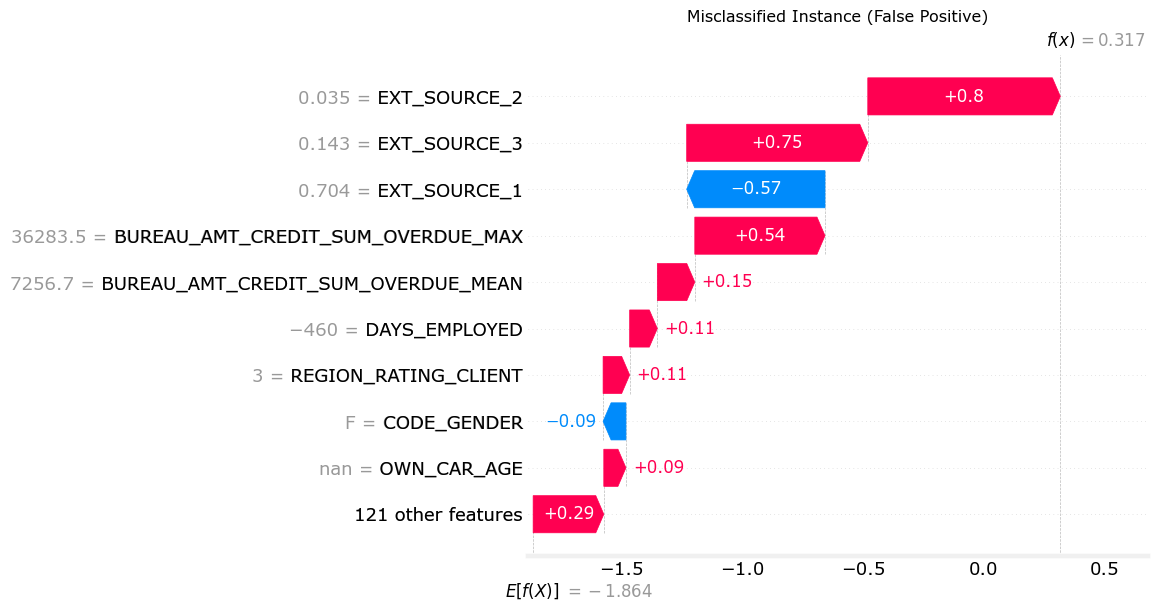

In [155]:
plt.title('Misclassified Instance (False Positive)')
shap.plots.waterfall(shap_values[misclassified_index_fp])

- Our newly tuned model achieved an ROC of 78%, indicating that there's a 78% chance the model will assign a higher probability of being a late payer to the actual late payer compared to a non-late payer, based on their respective probabilities. Our confusion matrix gives us another view: the model has a lot of false positives, indicating poor recall. For demonstration purposes, we also plotted the confusion matrix with a more strict threshold (0.35); we can see that our recall improves but at the cost of more false positives (precision-recall trade-off). 

- Our shap waterfall plots display a highly misclassified instance (false negative where probability was < 0.05 and false positives where probability > 0.5). One common theme we see is how influential the external source features are. In the first plot, we observe that the log odds drastically decreased since the client had high ext scores. We also observe that our model is biased by gender, where being female tends to reduce the log odds of late payment. In our second plot, we observe a similar pattern where since the ext source scores are so low, it drastically increases the log odds. Now, it's hard to pinpoint exactly why these instances might be misclassified; this is because many features can have interactions; for example, we see specific organization type increases the log odds; maybe that's because those organizations have some relationship with lower income, which therefore relate to late payments, etc. From a busniess perspective this is interesting because we want to be cautious of where our model is biased and making mistakes before presenting our product to retail banks. Our next step will involve more feature engineering; since the ext source features are so influential we can try out some averages or ratios that might help mitigate these misclassified instances.

**More Feature Engineering**

In [204]:
X_train_new_features = compute_ratio_features(X_train_perm)
X_val_new_features = compute_ratio_features(X_val_perm)

In [205]:
X_train_new_features = X_train_new_features.drop(
    columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
X_val_new_features = X_val_new_features.drop(
    columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

In [197]:
objective_v3 = get_objective_xgb(X_train_new_features, X_val_new_features,
                                 y_train, y_val)

In [307]:
study_v3 = optuna.create_study(direction='maximize')
study_v3.optimize(objective_v3, n_trials=75)

In [200]:
study_v3.best_value

0.7811362056567699

- We performed more feature engineering by testing various ratios such as credit to income ratio, the mean and standard deviation of external source features, and more. These features were created based on some common domain knowledge. That said, the model performance has just about stayed the same, indicating that these new features did not contribute much. Moving forward, we will try some custom imputation and encoding methods, as well as dropping columns with larger null values. Some things to note: We tried various combinations of these features, not just everything together, and the results were almost identical. 

**Custom Preprocessing & Removing Columns With Large Amount of Null Values**

In [270]:
X_train_filtered = filter_columns_by_null_threshold(X_train_perm, 50)
X_val_filtered = filter_columns_by_null_threshold(X_val_perm, 50)

preprocessor_with_nulls = create_preprocessor_with_null_threshold(
    X_train_perm, 100)
preprocessor_without_nulls = create_preprocessor_with_null_threshold(
    X_train_filtered, 50)

In [271]:
xgb_v3 = XGBClassifier(**best_params_v2, random_state=42, n_estimators=431)

In [272]:
pipelines = {
    'pipeline_with_nulls': build_pipeline(preprocessor_with_nulls, xgb_v3),
    'pipeline_without_nulls': build_pipeline(preprocessor_without_nulls,
                                             xgb_v3)
}

In [273]:
pipeline_results = {}
for name, pipeline in pipelines.items():
    if 'with_null' in name:
        pipeline.fit(X_train_perm, y_train)
        _, y_probas = get_preds_and_probas(pipeline, X_val_perm)
        pipeline_results[name] = roc_auc_score(y_val, y_probas)
    elif 'without_null' in name:
        pipeline.fit(X_train_filtered, y_train)
        _, y_probas = get_preds_and_probas(pipeline, X_val_filtered)

        pipeline_results[name] = roc_auc_score(y_val, y_probas)

In [309]:
print(
    f"ROC AUC custom preprocessing with nulls {pipeline_results['pipeline_with_nulls']}"
)
print(
    f"ROC AUC custom preprocessing without nulls {pipeline_results['pipeline_without_nulls']}"
)

ROC AUC custom preprocessing with nulls 0.7809385788903482
ROC AUC custom preprocessing without nulls 0.7753132580880308


- In our code above, we utilized pipelines to specify our own preprocessing. We imputed via median for numerical data and, most frequently, categorical data. Ideally, we would prefer to use KNN imputation, but that was not possible due to the size of the dataset and the time constraints. We also used target encoding to encode our categorical variables. We tested out one hot encoding, and it performed slightly worse. Overall, the results between using XGBoost internal handling of null and categorical vs. sklearn pipelines are almost identical. Next, we will test various sampling methods to see if we can improve the performance of our model.

**OverSampling vs UnderSampling**

In [289]:
ratio = 1 / 3
sampling_pipelines = {
    'smote_pipeline':
    build_pipeline(preprocessor_with_nulls, xgb_v3,
                   SMOTE(random_state=42, sampling_strategy=ratio)),
    'undersampling_pipeline':
    build_pipeline(
        preprocessor_with_nulls, xgb_v3,
        RandomUnderSampler(random_state=42, sampling_strategy=ratio))
}

In [290]:
sampling_pipeline_results = {}

for name, pipeline in sampling_pipelines.items():
    pipeline.fit(X_train_perm, y_train)
    y_preds, y_probas = get_preds_and_probas(pipeline, X_val_perm)
    sampling_pipeline_results[name] = [y_preds, y_probas]

In [292]:
y_preds_smote, y_probas_smote = sampling_pipeline_results['smote_pipeline']
y_preds_under, y_probas_under = sampling_pipeline_results[
    'undersampling_pipeline']
conf_matrix_smote = get_confusion_matrix_df(y_val, y_preds_smote)
conf_matrix_under = get_confusion_matrix_df(y_val, y_preds_under)

In [293]:
print(f'ROC AUC SMOTE: {np.round(roc_auc_score(y_val, y_probas_smote),3)}')
print(
    f'ROC AUC UnderSampling: {np.round(roc_auc_score(y_val, y_probas_under),3)}'
)

ROC AUC SMOTE: 0.776
ROC AUC UnderSampling: 0.779


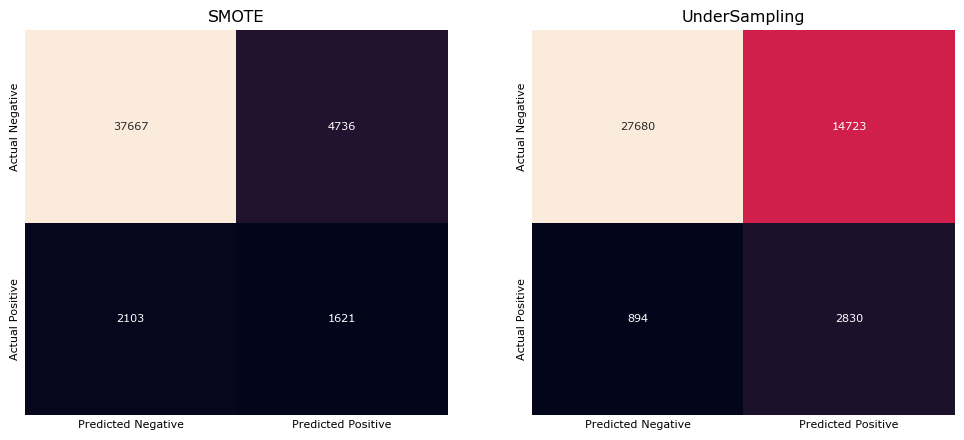

In [294]:
plot_double_conf_matrix(conf_matrix_smote, conf_matrix_under, 'SMOTE',
                        'UnderSampling')

- Our code above tests SMOTE and Undersampling and tries various ratios with the sampling strategy parameter. We can see our ROC AUC has dropped by a minimal amount. The confusion matrices show different results where our SMOTE confusion matrix is more aligned with our original model. The UnderSampling matrix displays many false positives but is much better at identifying positive cases (better recall). Similar results from SMOTE & Undersampling can be achieved by adjusting thresholds, so adding another layer of complexity to our model is unnecessary. Our next step will be evaluating our final model, the tuned model with the permutation importance features on the hold-out test set.

**Final Model & Evaluation On The Test Set**

In [295]:
xgb_final = XGBClassifier(**best_params_v2,
                          random_state=42,
                          enable_categorical=True,
                          n_estimators=750,
                          eval_metric='auc',
                          early_stopping_rounds=30)

In [296]:
xgb_final.fit(X_train_perm,
              y_train,
              eval_set=[(X_val_perm, y_val)],
              verbose=False)

XGBClassifier(alpha=0.19744634519170434, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8224093804785, device=None,
              early_stopping_rounds=30, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=0.11736488032866554,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.074848177981751,
              learning_rate=0.132632842111245, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=None, ...)

In [297]:
X_test_perm = X_test_agg[important_features_perm]

In [363]:
y_preds, y_probas = get_preds_and_probas(xgb_final, X_test_perm)

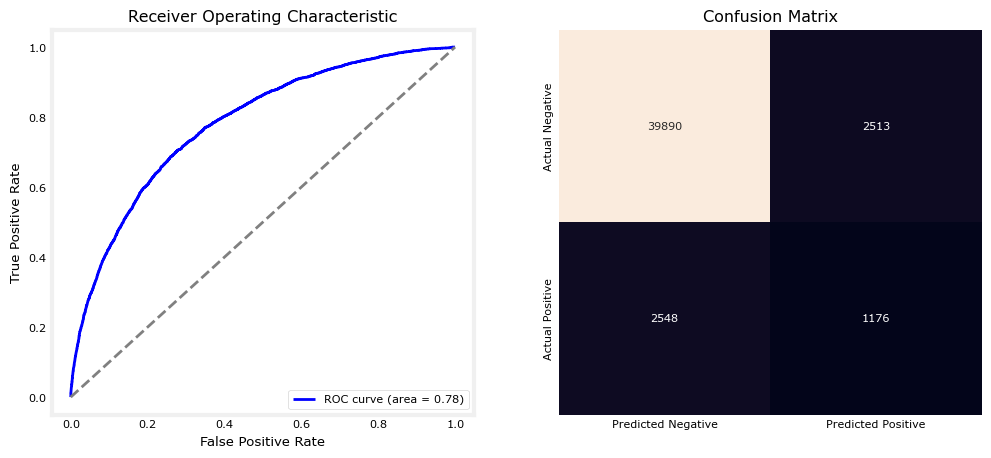

In [299]:
conf_matrix_final = get_confusion_matrix_df(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
plot_model_evaluation(fpr, tpr, roc_auc, conf_matrix_final)

- Our final evaluation of the untouched test set displays almost identical results as our evaluation. We achieved a roc auc of 78%, indicating that it has a 78% chance of correctly ranking a randomly selected late payer higher than a randomly chosen non-late payer in terms of the likelihood of being late on a payment. The confusion matrix also shows similar results as our evaluation of the validation set, where the model struggles with many false negatives; there is room for improvement.

**Shap Values**

In [300]:
explainer = shap.TreeExplainer(xgb_final, feature_names=X_train_perm.columns)
shap_values = explainer(X_test_perm)

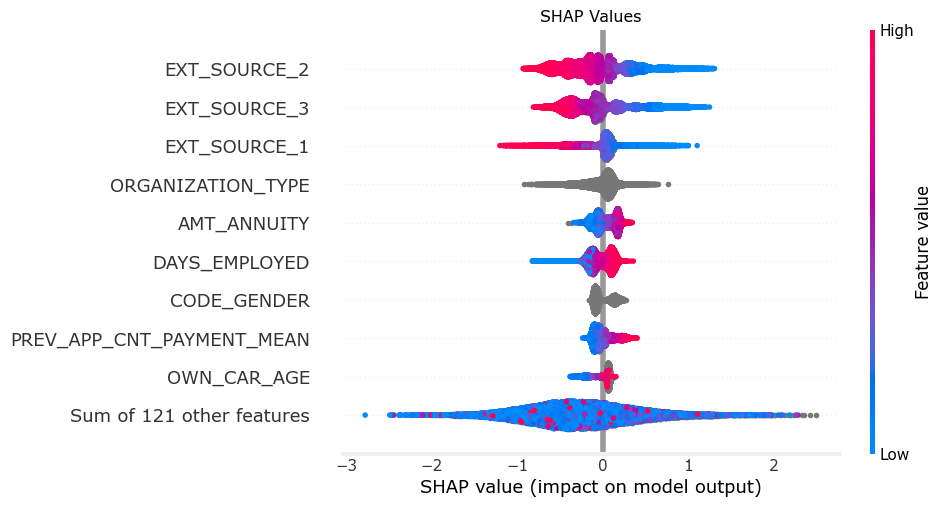

In [301]:
plt.title('SHAP Values')
shap.plots.beeswarm(shap_values, show=False)
plt.show()

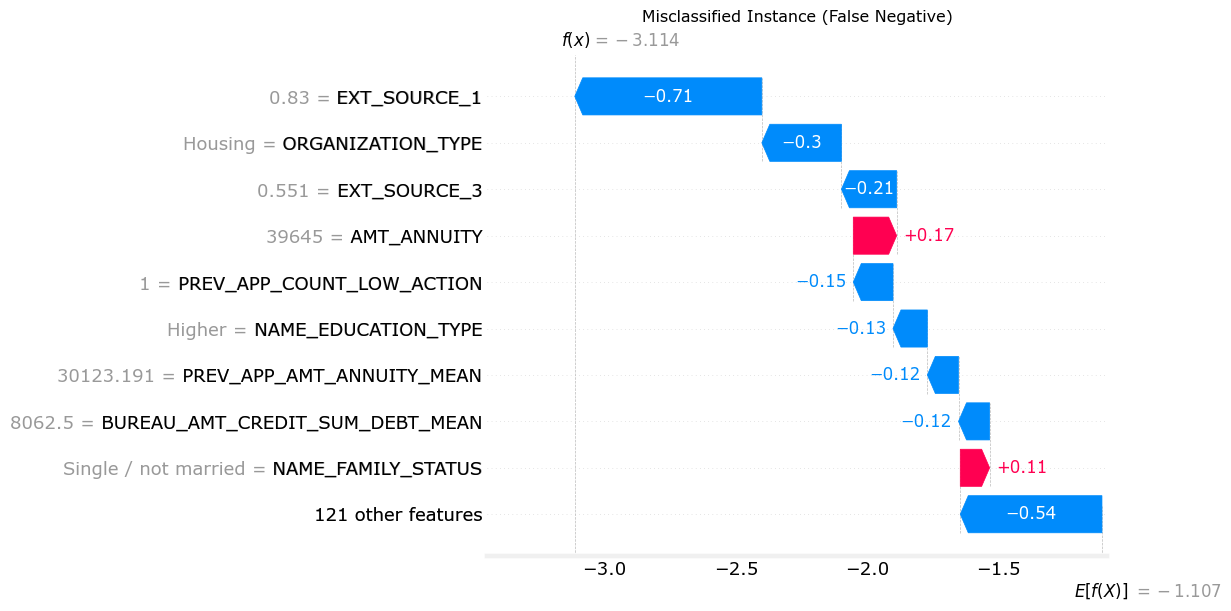

In [386]:
misclassified_index_fn = np.where((y_test == 1) & (y_probas < 0.05))[0][0]
plt.title('Misclassified Instance (False Negative)')
shap.plots.waterfall(shap_values[misclassified_index_fn])

- Our shap values plots, which allow for some explainability, display exciting insight. So, the first plot is a plot of feature importance. We see a similar pattern as we saw before, where external source features (representing some normalized score from an external source) were the most significant contributors to the model, followed by the organization type and annuity amount. Once again, we can see that our waterfall plot displays a misclassified instance (fn). Interestingly, most features push it towards the negative class, except for the high annuity amount. This displays that all of the features indicated that this client would not have any late payments, but in turn, they did. This shows that our indicators are not always 100% reliable, and many external factors can come into play when predicting risky loans.

**Saving Model & Test Data**

In [393]:
test_data_index = np.where(y_test == 1)[0][10]
test_data = X_test_perm.iloc[[test_data_indices]]

In [376]:
json_str = test_data.to_json(orient='records', lines=True)

with open('test_3.json', 'w') as file:
    file.write(json_str)

In [306]:
dump(xgb_final, 'xgb_final_model.joblib')

['xgb_final_model.joblib']

**Conclusion** 

At the beginning of the notebook, we had constructed our plan, which stated our business objectives and all the steps we followed to get a fully working product. Our initial analysis revealed features such as the ext sources, days employed, age, education type, and more, which all shared some relationship with a client having late payments. We developed various machine learning models, some with standard features and others with engineered features based on clients' previous history. We achieved an ROC AUC of 78% on the hold-out test set, indicating our model performed well in differentiating between clients who have/haven't had issues with late payments. From a business perspective, we have now built a fully functioning model that can act as a primary or secondary aid to provide risk evaluation as a service for retail banks. As stated above, our model can return probability values, which banks can use to create thresholds for classifying risky loans.

**Suggestion for Improvement**
- Having some baseline metric that the company/companies had before presenting our product and the hours/money spent would allow us to make a better comparison.
- Consider collecting more data to improve model performance, thus increasing the presentability of our product when meeting with retail banks.
- More domain knowledge could help in engineering better features and leading to improvements.